## Getting Data

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
df = pd.read_csv('fer2013.csv')
print(df.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


### Display Images

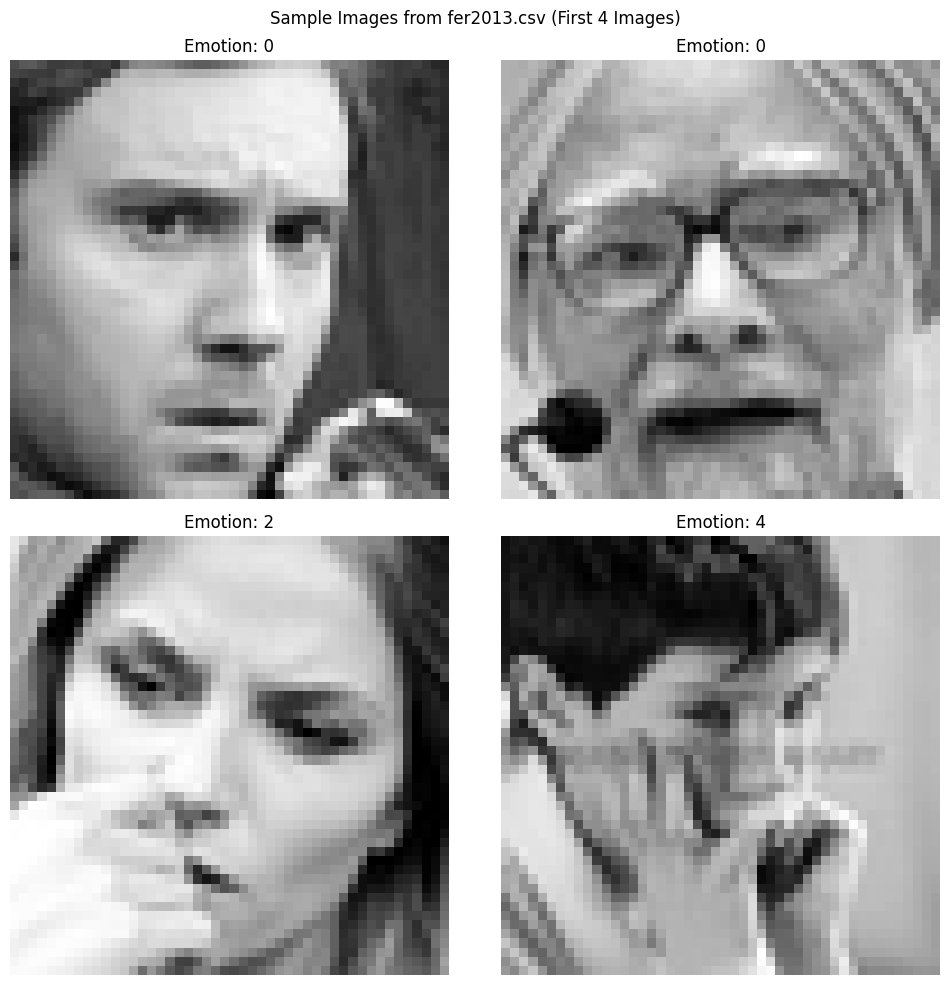

In [46]:
# Number of images to display in the grid (adjust as needed)
num_images = 4

# (0 = angry , 1= disgust, 2 = fear , 3 = happy , 4 = sad , 5 = surprise , 6 = neutral )

# Create a figure for subplots
fig, axes = plt.subplots(nrows=int(np.ceil(num_images / 2)), ncols=2, figsize=(10, 10))
axes = axes.ravel()  # Flatten the 2D array for easier iteration

# Loop through selected rows and display images
for i in range(num_images):
    sample_index = i  # You can adjust these indices to select specific images
    pixel_data = df.loc[sample_index, 'pixels'].split()
    pixels = np.array(pixel_data, dtype='uint8').reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f"Emotion: {df.loc[sample_index, 'emotion']}")  # Add emotion label
    axes[i].axis('off')  # Hide axes for cleaner grid

# Adjust layout (optional)
fig.suptitle(f"Sample Images from fer2013.csv (First {num_images} Images)", fontsize=12)
plt.tight_layout()  # Adjust spacing between subplots

# Show the plot
plt.show()

## Preparing Data

In [47]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

### converting from string to number

In [48]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')
X_train[0]

array([ 70,  80,  82, ..., 106, 109,  82], dtype=uint8)

### converting into categorical data

In [49]:
import keras
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

### Reshaping Data

In [50]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

## Image Augmentation

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(rescale=1./255)
batch_size = 64
datagen.fit(X_train)


In [52]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size)
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

## Building The Model using CNN

In [53]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [54]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())

    return model

In [55]:
model = FER_Model()
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_85               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_86               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_1 (MaxPooling2D)               │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop1_1 (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_87               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_88               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_3 (Conv2D)                     │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2_1 (MaxPooling2D)               │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2_1 (Dropout)                    │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_90               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_91               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,111,367 (50.02 MB)

 Trainable params: 13,103,431 (49.99 MB)

 Non-trainable params: 7,936 (31.00 KB)

None


In [36]:
num_epochs = 100
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Epoch 1/100


<ipython-input-36-6e64a3a0b9bb>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,


448/448 [==============================] - 57s 94ms/step - loss: 2.0416 - accuracy: 0.2098 - val_loss: 2.0100 - val_accuracy: 0.2463
Epoch 2/100
448/448 [==============================] - 39s 88ms/step - loss: 1.7929 - accuracy: 0.2487 - val_loss: 1.9052 - val_accuracy: 0.2385
Epoch 3/100
448/448 [==============================] - 39s 87ms/step - loss: 1.7609 - accuracy: 0.2638 - val_loss: 1.9013 - val_accuracy: 0.2594
Epoch 4/100
448/448 [==============================] - 39s 87ms/step - loss: 1.7246 - accuracy: 0.2919 - val_loss: 1.9869 - val_accuracy: 0.2934
Epoch 5/100
448/448 [==============================] - 39s 87ms/step - loss: 1.6662 - accuracy: 0.3352 - val_loss: 1.7410 - val_accuracy: 0.3572
Epoch 6/100
448/448 [==============================] - 39s 87ms/step - loss: 1.5856 - accuracy: 0.3754 - val_loss: 1.5215 - val_accuracy: 0.4138
Epoch 7/100
448/448 [==============================] - 39s 87ms/step - loss: 1.5237 - accuracy: 0.4051 - val_loss: 1.4593 - val_accuracy: 0.43

In [56]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

ValueError: The filename must end in `.weights.h5`. Received: filepath=model.h5

In [1]:
from tensorflow.keras.models import model_from_json
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')

In [2]:
import cv2
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [1]:
import cv2
from keras.preprocessing.image import img_to_array

# Function to preprocess an image for the model (adjust based on your model's requirements)
def preprocess_image(image):
    resized_image = cv2.resize(image, (48, 48))  # Resize to model input size
    image_pixels = img_to_array(resized_image)  # Convert to NumPy array
    image_pixels = np.expand_dims(image_pixels, axis=0)  # Add a new dimension
    image_pixels /= 255.0  # Normalize to 0-1 range
    return image_pixels

# Function to detect emotions (replace with your model's specific logic)
def predict_emotion(model, image_pixels):
    predictions = model.predict(image_pixels)  # Make predictions
    max_index = np.argmax(predictions[0])  # Find class with highest probability
    emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    emotion_prediction = emotion_detection[max_index]
    return emotion_prediction

# Load the image
image = cv2.imread('happy1.jpg')

# Check if image is loaded successfully
if image is None:
    print("Error: Image not found. Please check the image path.")
    exit()


face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_haar_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

# Loop through detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(image, pt1=(x, y), pt2=(x + w, y + h), color=(255, 0, 0), thickness=2)
    roi_gray = gray_image[y - 5:y + h + 5, x - 5:x + w + 5]
    roi_image = preprocess_image(roi_gray) cola # Preprocess the ROI

    emotion = predict_emotion(model, roi_image)  # Predict emotion

    # Display prediction on the frame
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 0.8
    FONT_THICKNESS = 2
    lable_color = (10, 10, 255)
    textX = int((image.shape[1] - len(emotion) * 13) / 2)  # Adjust text position based on emotion length
    textY = y - 10
    cv2.putText(image, emotion, (textX, textY), FONT, FONT_SCALE, lable_color, FONT_THICKNESS)

# Display the processed image
cv2.imshow('Emotion Detection', image)
cv2.waitKey(0)  # Wait for a key press to close the window
cv2.destroyAllWindows()

Error: Image not found. Please check the image path.


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [21]:
print(image.shape)

(854, 1280, 3)
